# JPK AFM data analysis for liquid samples

## Import libraries
Run this ONLY ONCE. Always restart kernel before running.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

import sys
import os
import pandas as pd
from datetime import datetime
from igor import binarywave
from PyQt5.QtWidgets import QApplication, QFileDialog, QListView, QTreeView, QAbstractItemView
#from IPython.display import Image
import matplotlib.pyplot as plt
import wetting, surfevol

app = QApplication(sys.argv)
plt.close('all')

#function to select multiple folders from dialog
def get_directories(caption=""):
    file_dialog = QFileDialog(caption=caption)
    file_dialog.setFileMode(QFileDialog.DirectoryOnly)
    file_dialog.setOption(QFileDialog.DontUseNativeDialog, True)
    file_view = file_dialog.findChild(QListView, 'listView')

    if file_view:
        file_view.setSelectionMode(QAbstractItemView.MultiSelection)
    f_tree_view = file_dialog.findChild(QTreeView)
    if f_tree_view:
        f_tree_view.setSelectionMode(QAbstractItemView.MultiSelection)

    if file_dialog.exec():
        paths = file_dialog.selectedFiles()
    else:
        paths = []

    return paths

#recognize if *.ibw file contains image data or force data
def categorize_ibw(filepath):
    ibw = binarywave.load(filepath)
    wdata = ibw["wave"]["wData"]
    meta_keys = []
    for line in str(ibw["wave"]["note"]).split("\\r"):
        if line.count(":"):
            key, val = line.split(":", 1)
            meta_keys.append(key)

    #CHECK THIS! MIGHT NOT WORK FOR SOME DATA
    if 'ForceDist' in meta_keys:
        file_cat = 'force'
    else:
        file_cat = 'image'
        
    return file_cat        

## Surface Evolver simulation data files

In [7]:
# plt.close('all')

# simu_folderpath = 'E:/Work/Surface Evolver/afm_pyramid/data/20220906_pyramid_sym_height0/' #20220906_cone_sym_height0,20220823_pyramid_sym_height0_ca30,20220822_tipangle_sym_height0,20220325_rfesp_np_fd

# #combine simulation data for tip geometry
# simu_df, simu_df_anal, fig_list = surfevol.combine_simul_dirs(simu_folderpath, 
#                                                               fd_fit_order=3, plot=False)

# #show plots below
# for f in fig_list:
#     display(f)
# plt.close('all')

simu_pyr = pd.read_excel('pyramid_simulation.xlsx', engine = 'openpyxl')
simu_pyr['Tip shape'] = 'Pyramid'
simu_cone = pd.read_excel('cone_simulation.xlsx', engine = 'openpyxl')
simu_cone['Tip shape'] = 'Cone'

simu_df = simu_pyr.append(simu_cone)

## Run Surface Tension code
Only works with classic Jupyter Notebook, not JupyterLab

In [55]:
%%javascript
Jupyter.notebook.execute_cells([8,10,12,14,16])

<IPython.core.display.Javascript object>

## JPK data raw files

In [56]:
jpk_file_paths, _ = QFileDialog.getOpenFileNames(caption='Select JPK data files') #JPK data (*.jpk,*.jpk-qi-data,*.jpk-force)
output_dir = QFileDialog.getExistingDirectory(caption='Select output data folder') #output folder
        
#separate image data and force data files
img_file_paths = []
fd_file_paths = []
for filepath in jpk_file_paths:
    file_ext = filepath.split('.')[-1]
    if file_ext in ['jpk', 'jpk-qi-data']:
        img_file_paths.append(filepath)
    elif file_ext in ['jpk-force']:
        fd_file_paths.append(filepath)
    elif file_ext in ['ibw']: #change this
        file_cat = categorize_ibw(filepath)
        if file_cat == 'image':
            img_file_paths.append(filepath)
        elif file_cat == 'force':
            fd_file_paths.append(filepath)
        
#make output directory
if output_dir == '':
        output_dir = os.path.dirname(jpk_file_paths[0]) + '/analysis' #default "analysis" folder
output_paths = []
for img_file_path in img_file_paths:
    file_name = os.path.basename(img_file_path)
    timestamp = datetime.today().strftime('%y%m%d-%H%M%S')
    output_path = f'{output_dir}/{file_name}_results_{timestamp}'
    os.makedirs(output_path, exist_ok=True)
    output_paths.append(output_path)

print('Image data:\n', img_file_paths, '\nForce data:\n', fd_file_paths, '\nOutput folder:\n', output_paths)

Image data:
 ['C:/Users/aranc/Desktop/Ranita/data for paper/20220812 water_Si_AC200_pegbrush/A0000.ibw'] 
Force data:
 ['C:/Users/aranc/Desktop/Ranita/data for paper/20220812 water_Si_AC200_pegbrush/A0014 no dwell.ibw'] 
Output folder:
 ['C:/Users/aranc/Desktop/Ranita/data for paper/20220812 water_Si_AC200_pegbrush/analysis/A0000.ibw_results_220930-171346']


## AFM image

Image file: C:/Users/aranc/Desktop/Ranita/data for paper/20220812 water_Si_AC200_pegbrush/A0000.ibw
Output folder: C:/Users/aranc/Desktop/Ranita/data for paper/20220812 water_Si_AC200_pegbrush/analysis/A0000.ibw_results_220930-171346
HeightTrace
HeightRetrace
AmplitudeTrace
AmplitudeRetrace
PhaseTrace
PhaseRetrace
ZSensorTrace
ZSensorRetrace


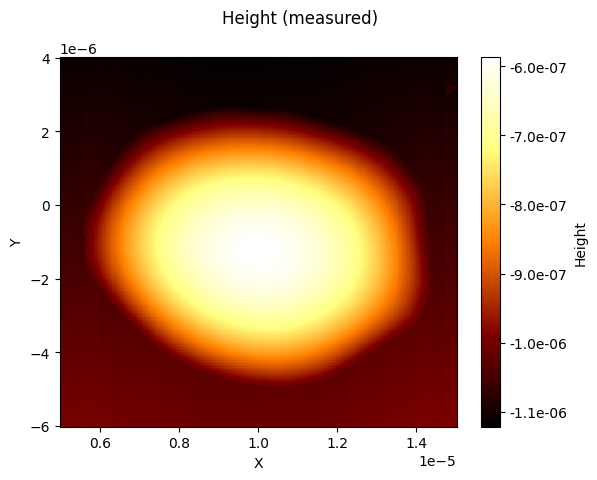

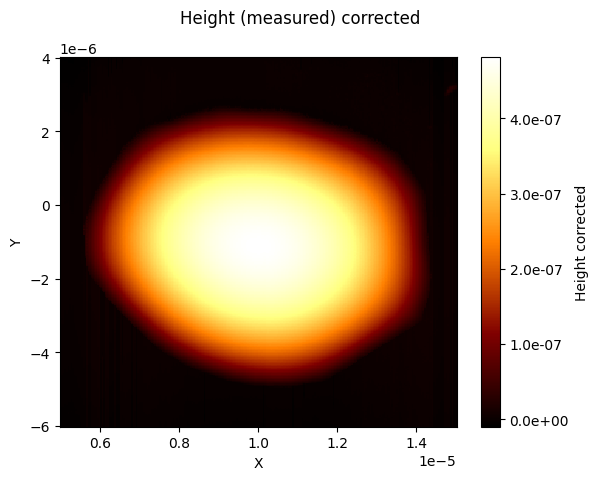

In [57]:
plt.close('all')
for img_file_path, output_path in zip(img_file_paths, output_paths):
    print('Image file:', img_file_path)
    print('Output folder:', output_path)
    afm_data, anal_data_h, fig_list =  wetting.get_afm_image(img_file_path, output_path, 
                                                             level_order=2, jump_tol=0.9)
    for fig in fig_list:
        display(fig)

plt.close('all')

## Get liquid drop properties

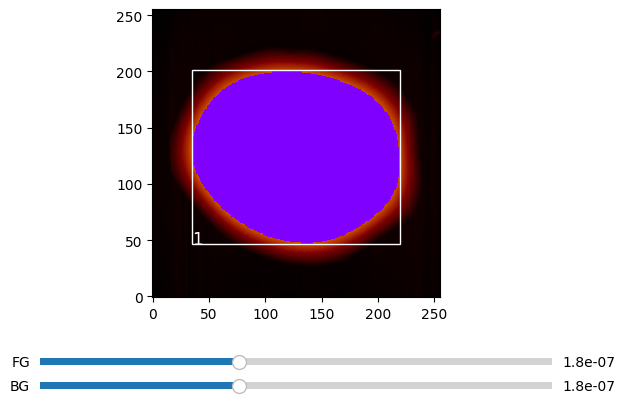

Label  Curvature  Contact Radius    Max Height  Max Height raw  \
0      1   0.000021        0.000004  4.714053e-07    4.815384e-07   

         Volume    Volume raw  Drop contact angle         s      R/d  \
0  1.425465e-17  1.151821e-17           12.288358  0.000002  9.28944   

                                            AFM file  
0  C:/Users/aranc/Desktop/Ranita/data for paper/2...

In [58]:
plt.close('all')
#drop analysis of AFM data
drop_df, img_anal, fig_list = wetting.get_drop_prop(afm_data, anal_data_h, output_paths[0])
drop_df['AFM file'] = img_file_paths[0]
for fig in fig_list:
    display(fig)
display(drop_df)
plt.close('all')

## Analyze force distance curves

Force file: C:/Users/aranc/Desktop/Ranita/data for paper/20220812 water_Si_AC200_pegbrush/A0014 no dwell.ibw
Raw
Defl
ZSnsr
slice {'extend': slice(0, 19982, None), 'retract': slice(19982, 39982, None)}
jumpin distance 4.6618674787168857e-07
Fit distance 3.8044345274101943e-07
FD wetted length: 6.099247651163845e-07
energy 1 nan


C:\Users\aranc\Desktop\Ranita\afm_surface_tension\venv\lib\site-packages\scipy\integrate\_quadrature.py:415: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\aranc\Desktop\Ranita\afm_surface_tension\venv\lib\site-packages\scipy\integrate\_quadrature.py:416: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\aranc\Desktop\Ranita\afm_surface_tension\venv\lib\site-packages\scipy\integrate\_quadrature.py:415: RuntimeWarning:

invalid value encountered in add



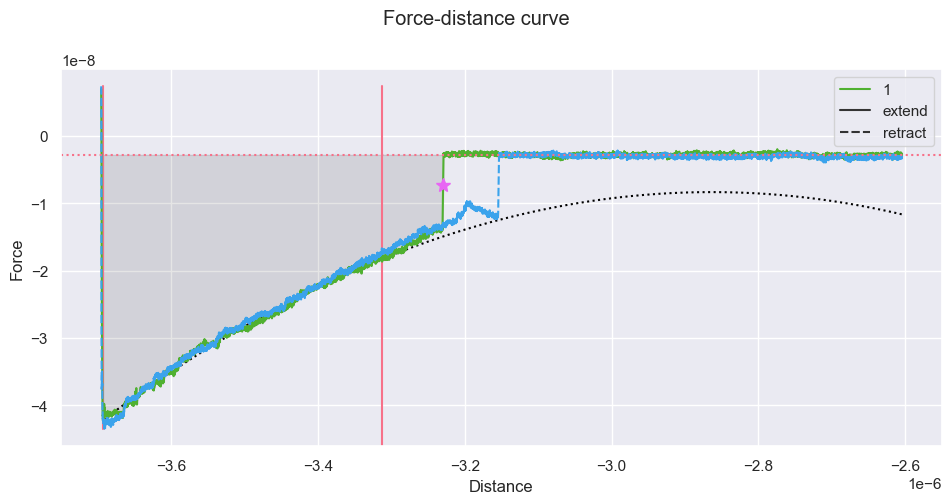

Label  Adhesion (FD)  Jumpin distance (FD)  Slope (FD)  Wetted length (FD)  \
0      1   3.944584e-08          4.661867e-07    0.062876        6.099248e-07   

   Fit distance (FD)  Adhesion energy (FD)  FD X position  FD Y position  \
0       3.804435e-07                   NaN       0.000007       0.000002   

                                             FD file  
0  C:/Users/aranc/Desktop/Ranita/data for paper/2...

In [59]:
plt.close('all')
fd_drop_df, fdfit_dict, fddata_dict, fig_list = wetting.analyze_drop_fd(fd_file_paths, afm_data, img_anal,
                                                                        force_cycle = 'approach', fit_order = 2,
                                                                        output_path = output_paths[0])

for fig in fig_list:
    #fig = Image(fig_path, width=400, height=400)
    display(fig)
display(fd_drop_df)

## Droplet surface tension calculation

In [63]:
#based on fixed AFM tip angle and contact angle 
plt.close('all')
plt.style.use('seaborn-bright')
contact_angle = 30 #Set fixed value to calculate its corresponsing surface tension
tip_angle = 8
transition_height = 400e-9
#combine droplet image and force result data
afm_df = drop_df.set_index('Label').join(fd_drop_df.set_index('Label'), how='right')

#calculate surface tension (from rupture distance)
output_df = wetting.get_surface_tension(afm_df, simu_df,contact_angle,tip_angle,
                                          fd_file_paths, output_paths[0], True)

Label
1    64.981901
Name: Surface Tension FD (mN), dtype: float64
    index  Unnamed: 0  Contact_Radius  Height  Force_Eng  Force_Calc  \
0     294           0        0.661050       0  -0.128233   -0.198017   
1     295           1        0.775658       0  -0.131429   -0.190319   
2     296           2        0.909262       0  -0.135131   -0.181638   
3     297           3        1.065688       0  -0.139641   -0.171915   
4     298           4        1.248905       0  -0.144456   -0.162139   
5     299           5        1.462786       0  -0.149544   -0.152176   
6     300           6        1.710910       0  -0.154681   -0.142422   
7     301           7        1.996452       0  -0.159694   -0.133012   
8     302           8        2.322187       0  -0.164434   -0.123990   
9     303           9        2.690561       0  -0.168585   -0.115035   
10    304          10        3.103803       0  -0.172711   -0.107597   
11    305          11        3.564011       0  -0.176598   -0.100659 

C:\Users\aranc\AppData\Local\Temp\ipykernel_167224\494662907.py:3: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



In [143]:
plt.close('all')
plt.style.use('seaborn-bright')
contact_angle = 50 #Set fixed value to calculate its corresponsing surface tension

#combine droplet image and force result data
afm_df = drop_df.set_index('Label').join(fd_drop_df.set_index('Label'), how='right')

#calculate surface tension (from rupture distance)
output_df = wetting.get_surface_tension3(afm_df, simu_df_anal,contact_angle,
                                          fd_file_paths, output_paths[0], True)

#output_df_filtered = output_df.dropna(subset=['FD file'])


# calculate surface tension from slopes of linear FD fitting
output_df2 = wetting.get_surface_tension2(afm_df, simu_df,
                                         tolerance=0.5,
                                         fd_file_paths=fd_file_paths,
                                         file_path=output_paths[0], save=True)
#output_df_filtered2 = output_df2[output_df['FD file'] != '']

# calculate surface tension by complete FD fitting using 2nd order poly approximation
output_df3, fig = wetting.get_surface_tension4(afm_df, simu_df, fdfit_dict,fddata_dict,
                                              file_path=output_paths[0], save=True)

ax = output_df.plot(x='Contact Radius', y=['Surface Tension (rupture, mN)','Surface Tension (fixed, mN)'],
                             marker = "o", ls="")
ax.plot(output_df2['Contact Radius'],output_df2['Surface Tension FD (mN)'],
        label="Surface Tension (slope, mN)", marker = "o", ls="")
ax.plot(output_df3['Contact Radius'],output_df3['Surface Tension (error min, mN)'],
        label="Surface Tension (polyfit, mN)", marker = "o", ls="")
ax.legend()

ax.ticklabel_format(axis='x', style='sci', scilimits=(-6,-6))
#show and save plot
fig1 = ax.get_figure()
display(fig1)
fig1.savefig(f'{output_paths[0]}/surface_tension.png', bbox_inches = 'tight',
             transparent = False)

plot_vars = ['Drop contact angle','Tip contact angle (rupture)',
             'Adhesion (FD)', 'Wetted length (FD)']
ax = output_df.plot(x='Contact Radius', y=plot_vars,title = plot_vars,
                             marker = "o", ls="", subplots=True, layout=(2,2), figsize=(11,10),
                             legend=False)
#number formatting
ax[1][0].ticklabel_format(axis='y', style='sci', scilimits=(-9,-9))
ax[1][1].ticklabel_format(axis='y', style='sci', scilimits=(-9,-9))
ax[1][1].ticklabel_format(axis='x', style='sci', scilimits=(-6,-6))
#show and save plot
fig2 = ax[0][0].get_figure()
display(fig2)
fig2.savefig(f'{output_paths[0]}/other_results.png', bbox_inches = 'tight',
             transparent = False)

display(output_df)
display(output_df2)
display(output_df3)
display(fig)
fig.savefig(f'{output_paths[0]}/polyfit_result.png', bbox_inches = 'tight',
            transparent = False)
plt.close('all')

KeyError: 'Contact_Radius'

## Combine results from different folders

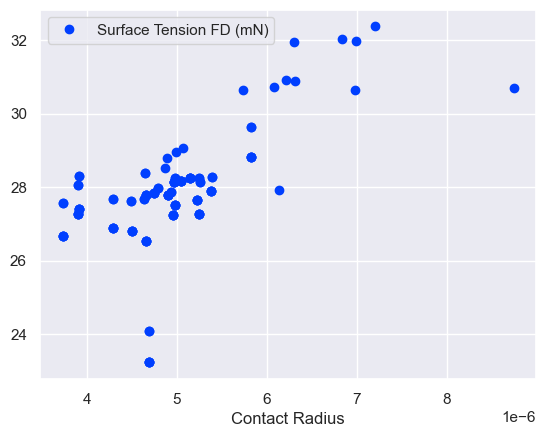

Label  Curvature  Contact Radius    Max Height  Max Height raw  \
0       1   0.000010        0.000005  1.129625e-06    1.132029e-06   
1       2   0.000012        0.000005  1.267849e-06    1.268971e-06   
2       3   0.000010        0.000005  1.097636e-06    1.104541e-06   
3       4   0.000012        0.000005  1.231684e-06    1.233543e-06   
4       2   0.000017        0.000005  8.867802e-07    8.867489e-07   
..    ...        ...             ...           ...             ...   
2       4   0.000014        0.000004  7.417557e-07    7.447675e-07   
3       7   0.000015        0.000005  8.292707e-07    8.304973e-07   
4       6   0.000013        0.000004  6.999905e-07    7.018641e-07   
5       8   0.000015        0.000005  8.256235e-07    8.290326e-07   
6       9   0.000015        0.000005  7.337082e-07    7.388331e-07   

          Volume    Volume raw  Drop contact angle         s       R/d  ...  \
0   3.976865e-17  3.423997e-17           27.089862  0.000002  4.150957  ...   
1   5.595219e-17  4.971641e-17           27.154965  0.000002  4.140624  ...   
2   3.812218e-17  3.246266e-17           26.512106  0.000002  4.244838  ...   
3   5.380340e-17  4.763145e-17           26.526822  0.000002  4.242397  ...   
4   4.056837e-17  3.621710e-17           18.745951  0.000002  6.058242  ...   
..           ...           ...                 ...       ...       ...  ...   
2   2.368843e-17  1.975953e-17           18.767056  0.000002  6.051307  ...   
3   3.200639e-17  2.819318e-17           19.082420  0.000002  5.949474  ...   
4   2.035803e-17  1.689900e-17           18.560332  0.000002  6.119919  ...   
5   3.240291e-17  2.841423e-17           18.842495  0.000002  6.026639  ...   
6   2.510504e-17  2.089713e-17           17.940907  0.000002  6.334893  ...   

   FD X position  FD Y position  \
0       0.000031      -0.000030   
1       0.000015      -0.000019   
2       0.000043      -0.000014   
3       0.000027      -0.000003   
4      -0.000006      -0.000035   
..           ...            ...   
2      -0.000015      -0.000026   
3      -0.000010      -0.000013   
4       0.000008      -0.000015   
5       0.000016      -0.000009   
6      -0.000004      -0.000003   

                                              FD file  Tip angle     F_fit  \
0   E:/Work/AFM/20220910 mineral oil_mica_RFESPA_p...         15 -0.596593   
1   E:/Work/AFM/20220910 mineral oil_mica_RFESPA_p...         15 -0.596119   
2   E:/Work/AFM/20220910 mineral oil_mica_RFESPA_p...         15 -0.600787   
3   E:/Work/AFM/20220910 mineral oil_mica_RFESPA_p...         15 -0.600681   
4   E:/Work/AFM/20220910 mineral oil_mica_RFESPA_p...         15 -0.652100   
..                                                ...        ...       ...   
2   E:/Work/AFM/20220910 mineral oil_mica_RFESPA_p...         15 -0.659668   
3   E:/Work/AFM/20220910 mineral oil_mica_RFESPA_p...         15 -0.656653   
4   E:/Work/AFM/20220910 mineral oil_mica_RFESPA_p...         15 -0.661666   
5   E:/Work/AFM/20220910 mineral oil_mica_RFESPA_p...         15 -0.658943   
6   E:/Work/AFM/20220910 mineral oil_mica_RFESPA_p...         15 -0.667783   

        yd/F  Surface Tension FD (mN)  Simulation contact angle  \
0   0.266773                23.228097                        30   
1   0.266985                27.270347                        30   
2   0.264911                26.535970                        30   
3   0.264958                27.656193                        30   
4   0.244065                27.889762                        30   
..       ...                      ...                       ...   
2   0.241265                27.621803                        30   
3   0.242373                27.869771                        30   
4   0.240537                27.688918                        30   
5   0.241531                28.235952                        30   
6   0.238333                28.375282                        30   

                                          Folder na

In [54]:
plt.cla()
plt.clf()
plt.close('all')
folder_paths = get_directories("Select analysis result folder (containing output Excel file)")
summary_df = wetting.combine_result_spreadsheets(folder_paths)
summary_df = summary_df[summary_df['FD file'] != '']

surf_ten_label = [#'Surface Tension (rupture, mN)', 
                  #'Surface Tension (fixed, mN)',
                  'Surface Tension FD (mN)', 
                  #'Surface Tension (error min, mN)'
                ]
#summary_df = summary_df[summary_df[surf_ten_label] != 0]
#summary_df.replace(0, np.nan, inplace=True)
timestamp = datetime.today().strftime('%y%m%d-%H%M%S')
summary_df.to_excel(f'{output_dir}/summary_data_all_{timestamp}.xlsx', index=None)

ax = summary_df.plot(x='Contact Radius', 
                     y=surf_ten_label,
                     marker = "o", ls="")

ax.ticklabel_format(axis='x', style='sci', scilimits=(-6,-6))
#show and save plot
fig3 = ax.get_figure()
fig3.savefig(f'{output_dir}/summary_plot_all_{timestamp}.png', bbox_inches = 'tight',
             transparent = False)
display(fig3)
display(summary_df)
plt.close('all')

## Combine multiple FD curves

In [84]:
plt.close('all')
# combine multiple fd curves
output_path = ''
fd_file_paths, _ = QFileDialog.getOpenFileNames()
wetting.combine_fd(fd_file_paths, zero_shift=True, 
                   output_dir=output_path,save=False)
#wetting.get_adhesion_from_fd(fd_file_paths)

Raw
Defl
ZSnsr


## Optional codes

In [ ]:
# calculate contact angle from fd curve
label = 5 #INPUT
label_df = drop_df[drop_df['Label']==label]
s = label_df['s'].iloc[0]
R = round(label_df['R/s'].iloc[0])
contact_angle = wetting.get_contact_angle(fd_file_paths[0], simu_df,
                                         R, s, fit_index=5000)

